In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


In [2]:
# 필요한 종속성(라이브러리 및 설정)을 가져옵니다.

# 운영 체제와 관련된 작업을 수행하는 데 사용하는 라이브러리를 가져옵니다.
import os

# 경고 메시지를 무시하기 위한 설정입니다.
import warnings
warnings.filterwarnings('ignore')

# 데이터 조작 및 분석을 위한 데이터프레임 라이브러리를 가져옵니다.
import pandas as pd

# 수학 및 배열 연산을 위한 라이브러리를 가져옵니다.
import numpy as np

# 데이터 시각화를 위한 라이브러리를 가져옵니다.
import matplotlib.pyplot as plt

# 이미지 처리를 위한 OpenCV 라이브러리를 가져옵니다.
import cv2

# 데이터 셔플링 및 모델 평가를 위한 라이브러리를 가져옵니다.
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# TensorFlow 라이브러리를 가져옵니다.
import tensorflow as tf

# TensorFlow에서 사용할 레이어 및 모델 관련 라이브러리를 가져옵니다.
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# 이미지 크기 설정
IMG_SIZE = 40, 40

# 배치 크기 설정
BATCH_SIZE = 32

# 무작위성을 위한 시드 설정
SEED = 5

# TensorFlow의 데이터 파이프라인 최적화를 위한 설정
AUTO = tf.data.AUTOTUNE

In [3]:
# 이미지 경로와 해당 클래스(라벨)를 포함하는 주요 데이터프레임을 생성합니다.

# 이미지 경로를 포함하는 리스트를 생성하는 함수 정의
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path

# 각 클래스에 대한 이미지 경로 리스트를 생성합니다.
data_moon = create_images_list('./Moon_jellyfish')
data_barrel = create_images_list('./barrel_jellyfish')
data_blue = create_images_list('./blue_jellyfish')
data_compass = create_images_list('./compass_jellyfish')
data_lions_mane = create_images_list('./lions_mane_jellyfish') 
data_mauve_stinger = create_images_list('./mauve_stinger_jellyfish')

# 클래스(라벨)와 해당 클래스 이름을 연결하는 룩업 테이블 생성
jellyfish_classes = {0:'Moon', 1: 'Barrel', 2: 'Blue', 3: 'Compass', 4: 'Lion’s mane', 5: 'Mauve stinger'}

# 데이터프레임을 생성하고 이미지 경로와 클래스(라벨)를 열에 추가합니다.
data_df = pd.concat([
    pd.DataFrame({"img": np.array(data_moon), "label": 0}),
    pd.DataFrame({"img": np.array(data_barrel), "label": 1}),
    pd.DataFrame({"img": np.array(data_blue), "label": 2}),
    pd.DataFrame({"img": np.array(data_compass), "label": 3}),
    pd.DataFrame({"img": np.array(data_lions_mane), "label": 4}),
    pd.DataFrame({"img": np.array(data_mauve_stinger), "label": 5})
], ignore_index=True)

# 데이터프레임을 무작위로 섞고 인덱스를 재설정합니다.
data_df = shuffle(data_df, random_state=SEED).reset_index(drop=True)

# 데이터프레임의 상위 5개 행을 출력합니다.
data_df.head()

,img,label
0,./compass_jellyfish/aug-59-03.jpg,3
1,./lions_mane_jellyfish/34.jpg,4
2,./mauve_stinger_jellyfish/aug-18-23.jpg,5
3,./mauve_stinger_jellyfish/aug-85-35.JPG,5
4,./Moon_jellyfish/32.jpg,0


## Train , val, test 데이터셋 생성

In [4]:
# 데이터를 학습(train) 및 검증(valid) 세트와 테스트 세트로 분할합니다.

# 테스트 세트의 크기를 결정합니다. 데이터 프레임(data_df)의 전체 크기의 15%로 설정합니다.
test_idx = data_df.shape[0] * 15 // 100  # 15 %를 테스트용으로 설정

# 학습(train) 및 검증(valid) 데이터프레임(train_df)을 만듭니다.
# 검증(valid) 데이터프레임은 테스트용 데이터로 사용될 것입니다.
# reset_index()를 사용하여 새로운 인덱스를 생성하고, drop=True로 이전 인덱스를 제거합니다.
train_df = data_df[test_idx:].reset_index(drop=True)

# 테스트 데이터프레임(test_df)을 만듭니다.
# 테스트용 데이터는 데이터프레임의 처음부터 테스트 인덱스까지 가져옵니다.
# reset_index()를 사용하여 새로운 인덱스를 생성하고, drop=True로 이전 인덱스를 제거합니다.
test_df = data_df[:test_idx].reset_index(drop=True)

# 학습(train) 및 검증(valid) 데이터프레임의 크기와 테스트 데이터프레임의 크기를 출력합니다.
print("학습(train) 및 검증(valid) 데이터프레임의 크기 -> ", train_df.shape[0])
print("테스트 데이터프레임의 크기 -> ", test_df.shape[0])

학습(train) 및 검증(valid) 데이터프레임의 크기 ->  765
테스트 데이터프레임의 크기 ->  135


## Custom ConvMixer Layer 사용

In [5]:
# 필요한 라이브러리 가져오기
from tensorflow.keras.layers import Layer, DepthwiseConv2D, Conv2D, Activation, BatchNormalization, Add

# ConvMixerBlock 클래스 정의
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        
        # 클래스 변수 초기화
        self.filters = filters         # 필터 수
        self.kernel_size = kernel_size # 커널 크기
        self.patch_size = patch_size   # 패치 크기
        
        # Depthwise 합성곱 레이어 초기화
        self.deepwise = DepthwiseConv2D(kernel_size=kernel_size, padding='same')
        # 1x1 합성곱 레이어 초기화
        self.conv1 = Conv2D(filters, kernel_size=1)
        # GELU 활성화 함수 초기화
        self.act = Activation('gelu')
        # 배치 정규화 레이어 초기화
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        # 입력을 Depthwise 합성곱 레이어에 전달
        X = self.deepwise(inputs)
        # GELU 활성화 함수 적용
        X = self.act(X)
        # 첫 번째 배치 정규화 레이어 적용
        X = self.bn1(X)
        # 입력과 결과를 더함 (잔차 연결)
        X = Add()([X, inputs])
        # 1x1 합성곱 레이어 적용
        X = self.conv1(X)
        # 다시 GELU 활성화 함수 적용
        X = self.act(X)
        # 두 번째 배치 정규화 레이어 적용
        X = self.bn2(X)
            
        return X

    def get_config(self):
        base_config = super().get_config()
        
        # 클래스 설정 반환
        return {
            **base_config,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

## Model

In [6]:
# 필요한 라이브러리 가져오기
from tensorflow_addons.optimizers import AdamW

# 모델 특징(Feature) 수 설정
FEATURES = 256

# 입력 데이터의 형태를 정의합니다.
inp = Input(shape=(*IMG_SIZE, 3))

# 2x2 크기의 2D 합성곱 레이어를 적용합니다.
X = Conv2D(FEATURES, 2, 2)(inp)

# GELU 활성화 함수를 적용합니다.
X = Activation('gelu')(X)

# 배치 정규화를 적용합니다.
X = BatchNormalization()(X)

# ConvMixerBlock을 여러 번 적용합니다.
# 각 ConvMixerBlock은 동일한 구조를 가지고 있으며, FEATURES, 5, 2의 파라미터를 가지고 초기화됩니다.
# 이러한 블록들은 특징 추출을 수행하고 모델의 복잡성을 증가시키는 역할을 합니다.

# 첫 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_1')(X)

# 두 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_2')(X)

# 세 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_3')(X)

# 네 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_4')(X)

# 다섯 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_5')(X)

# 여섯 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_6')(X)

# 일곱 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_7')(X)

# 여덟 번째 ConvMixerBlock
X = ConvMixerBlock(FEATURES, 5, 2, name='CONVMIXER_8')(X)

# Global Average Pooling을 적용합니다.
X = GlobalAveragePooling2D()(X)

# 출력 레이어를 생성하고 softmax 활성화 함수를 적용합니다.
out = Dense(6, activation='softmax')(X)

# 모델을 생성합니다.
model = Model(inputs=inp, outputs=out)

# 모델 요약 정보를 출력합니다.
model.summary()

import tensorflow_addons as tfa

# TensorFlow Addons 라이브러리에서 AdamW 옵티마이저를 가져와서 모델을 컴파일합니다.
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 256)       3328      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 256)       1024      
_________________________________________________________________
CONVMIXER_1 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_2 (ConvMixerBlock) (None, 20, 20, 256)       74496     
_________________________________________________________________
CONVMIXER_3 (ConvMixerBlock) (None, 20, 20, 256)       74496 

### 데이터 파이프라인 구축

In [7]:
# 이미지를 읽어오고 크기 조정 및 정규화를 수행하는 전처리 함수
def img_preprocessing(image, label):
    img = tf.io.read_file(image)  # 이미지 파일을 읽어옵니다.
    img = tf.io.decode_jpeg(img, channels=3)  # JPEG 포맷의 이미지를 디코딩하고 채널을 3으로 설정합니다.
    img = tf.image.resize(img, size=IMG_SIZE)  # 이미지 크기를 지정된 IMG_SIZE로 조정합니다.
    img = tf.cast(img, tf.float32) / 255.0  # 이미지를 부동 소수점 타입으로 변환하고 0~1 사이로 정규화합니다.
    
    return img, label

# 기본적인 데이터 증강을 수행하는 함수
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)  # 이미지를 무작위로 좌우로 뒤집습니다.
    img = tf.image.random_flip_up_down(img)  # 이미지를 무작위로 상하로 뒤집습니다.
    
    return image, label

In [8]:
# 테스트 데이터셋 로더 생성 및 tf.data.Dataset 생성

# tf.data.Dataset.from_tensor_slices()를 사용하여 테스트 데이터를 로드합니다.
test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))

# 이미지 전처리 함수인 img_preprocessing을 적용하고 병렬 처리를 수행합니다.
# num_parallel_calls를 사용하여 병렬 처리를 지정합니다.
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls=AUTO)
                .batch(BATCH_SIZE)  # 배치 크기를 설정합니다.
                .prefetch(AUTO))  # 데이터를 미리 로드하여 효율성을 높입니다.

## 10 Folds Training

In [9]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 20
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*90)
    print(str(i+1) + '.fold training')
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)
    
    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)
    
# 전체 평균 결과 출력
print('-' * 90)
print('모든 폴드에서의 평균 테스트 정확도: {0:.3f} %'.format(average_accuracy))
print('모든 폴드에서의 평균 테스트 손실: {0:.3f}'.format(average_loss))

------------------------------------------------------------------------------------------
1.fold training
5/5 [==============================] - 0s 28ms/step - loss: 2.5272 - acc: 0.1407 - top_3_acc: 0.5259
Test Loss: 2.527
Test Accuracy: 14.074 %
Test Sparse Top 2 Accuracy: 52.59 %
------------------------------------------------------------------------------------------
2.fold training
5/5 [==============================] - 0s 20ms/step - loss: 0.8375 - acc: 0.6963 - top_3_acc: 0.9630
Test Loss: 0.837
Test Accuracy: 69.630 %
Test Sparse Top 2 Accuracy: 96.30 %
------------------------------------------------------------------------------------------
3.fold training
5/5 [==============================] - 0s 20ms/step - loss: 0.6057 - acc: 0.7852 - top_3_acc: 0.9852
Test Loss: 0.606
Test Accuracy: 78.519 %
Test Sparse Top 2 Accuracy: 98.52 %
------------------------------------------------------------------------------------------
4.fold training
5/5 [==============================] -

In [17]:
# 전체 평균 결과 출력
print('-' * 90)
print('모든 폴드에서의 평균 테스트 정확도: {0:.3f} %'.format(average_accuracy))
print('모든 폴드에서의 평균 테스트 손실: {0:.3f}'.format(average_loss))

------------------------------------------------------------------------------------------
모든 폴드에서의 평균 테스트 정확도: 73.333 %
모든 폴드에서의 평균 테스트 손실: 0.764


## 학습 결과

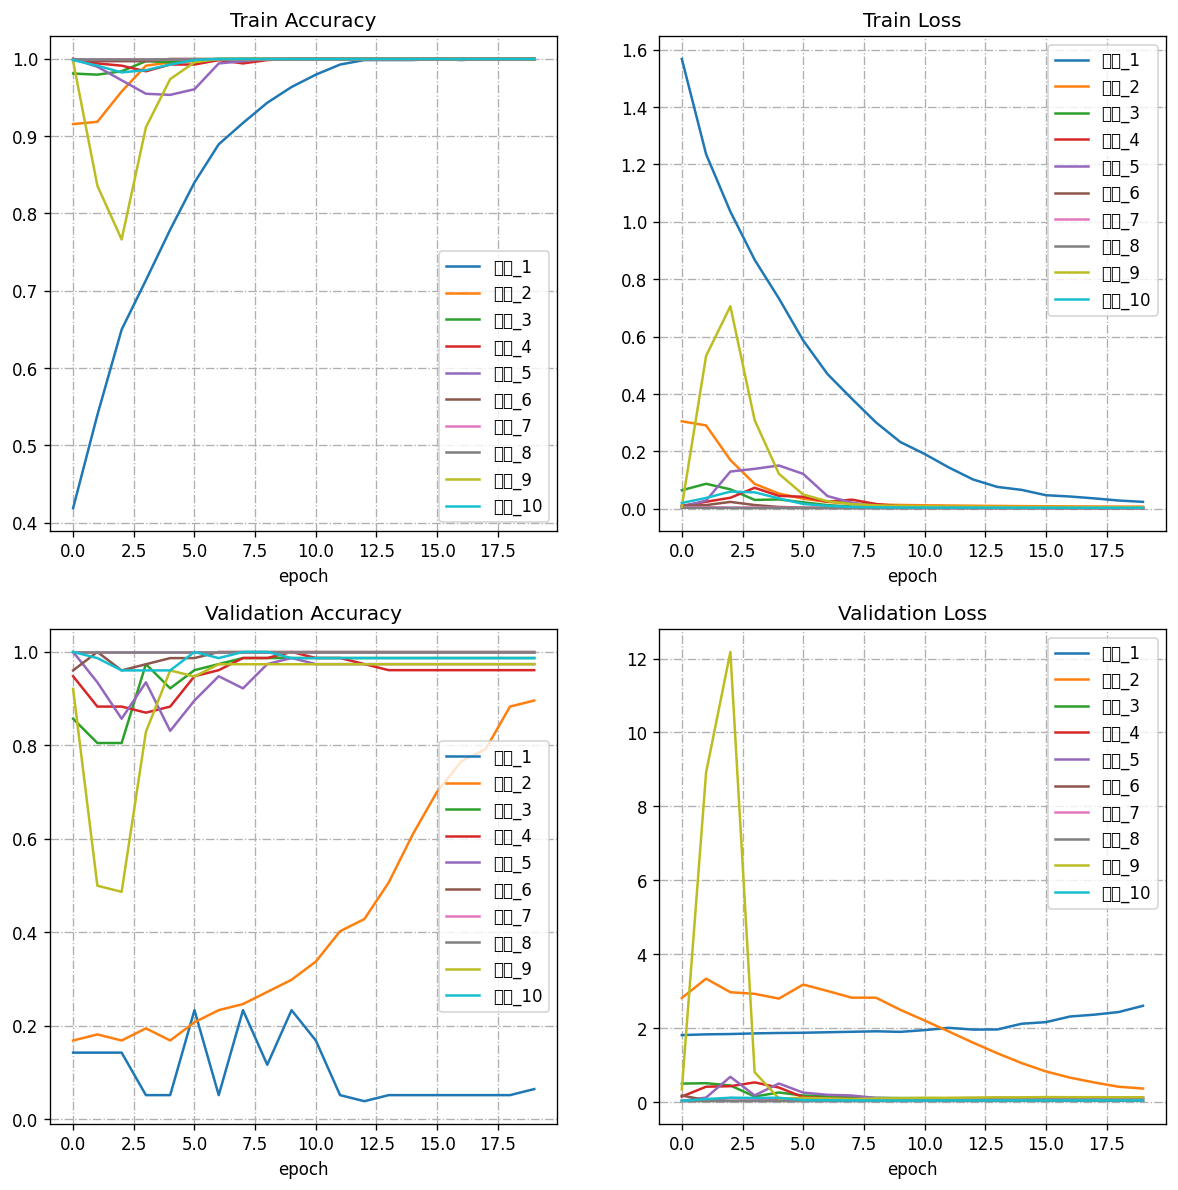

In [11]:
import matplotlib.pyplot as plt

# 2x2 서브플롯 생성, 그림 크기와 DPI 설정
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=120)

# 각 폴드의 이름을 저장할 리스트
folds_name = []

# 첫 번째 서브플롯 (Train Accuracy) 설정
axs[0][0].set_title('Train Accuracy')
axs[0][0].grid(linestyle='dashdot')
axs[0][0].set_xlabel('epoch', fontsize=10)

# 각 폴드에 대한 Train Accuracy 그래프 그리기
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('폴드_' + str(i + 1))

# 폴드 이름을 범례로 추가
axs[0][0].legend(folds_name, fontsize=10)

# 두 번째 서브플롯 (Train Loss) 설정
axs[0][1].set_title('Train Loss')
axs[0][1].grid(linestyle='dashdot')
axs[0][1].set_xlabel('epoch', fontsize=10)

# 각 폴드에 대한 Train Loss 그래프 그리기
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])

# 폴드 이름을 범례로 추가
axs[0][1].legend(folds_name, fontsize=10)

# 세 번째 서브플롯 (Validation Accuracy) 설정
axs[1][0].set_title('Validation Accuracy')
axs[1][0].grid(linestyle='dashdot')
axs[1][0].set_xlabel('epoch', fontsize=10)

# 각 폴드에 대한 Validation Accuracy 그래프 그리기
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])

# 폴드 이름을 범례로 추가
axs[1][0].legend(folds_name, fontsize=10)

# 네 번째 서브플롯 (Validation Loss) 설정
axs[1][1].set_title('Validation Loss')
axs[1][1].grid(linestyle='dashdot')
axs[1][1].set_xlabel('epoch', fontsize=10)

# 각 폴드에 대한 Validation Loss 그래프 그리기
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])

# 폴드 이름을 범례로 추가
axs[1][1].legend(folds_name, fontsize=10)

# 그림 표시
plt.show()

## Ensemble Test Prediction

In [12]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

## Test Classifiation Report

In [13]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(jellyfish_classes.values()))
print(clf)

               precision    recall  f1-score   support

         Moon       0.60      0.94      0.73        16
       Barrel       0.62      0.79      0.70        19
         Blue       0.95      0.58      0.72        33
      Compass       0.93      0.62      0.74        21
  Lion’s mane       0.88      0.94      0.91        16
Mauve stinger       0.80      0.93      0.86        30

     accuracy                           0.78       135
    macro avg       0.80      0.80      0.78       135
 weighted avg       0.82      0.78      0.77       135



## Test Confusion Matrix

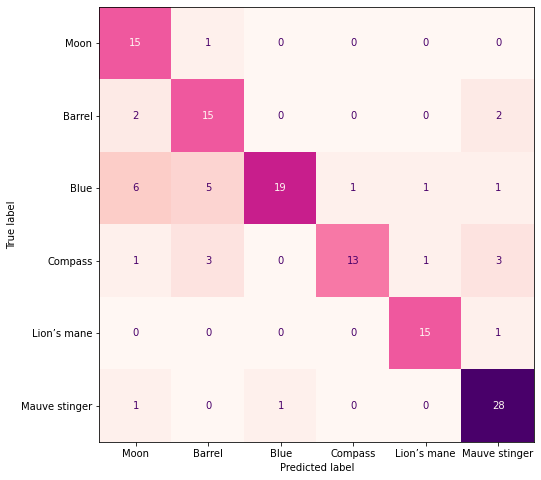

In [14]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(jellyfish_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

## Test Predictions

In [15]:
# 무작위로 선택된 테스트 샘플 5개를 생성하고 예측 결과를 시각화하는 함수
def random_test_sample_with_prediction(SEED):
    # 지정된 SEED를 사용하여 무작위 인덱스 5개를 선택합니다.
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    
    # 선택된 인덱스에서 배치 및 image 인덱스를 계산합니다.
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    # 1x5 서브플롯을 생성하고 그림 크기와 DPI를 설정합니다.
    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        # 선택된 image와 해당 라벨을 가져옵니다.
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        
        # 예측이 실제 라벨과 일치하는지 확인하고 적절한 제목과 색상을 설정합니다.
        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (No.: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize=8, color='green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (No.: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize=8, color='red')

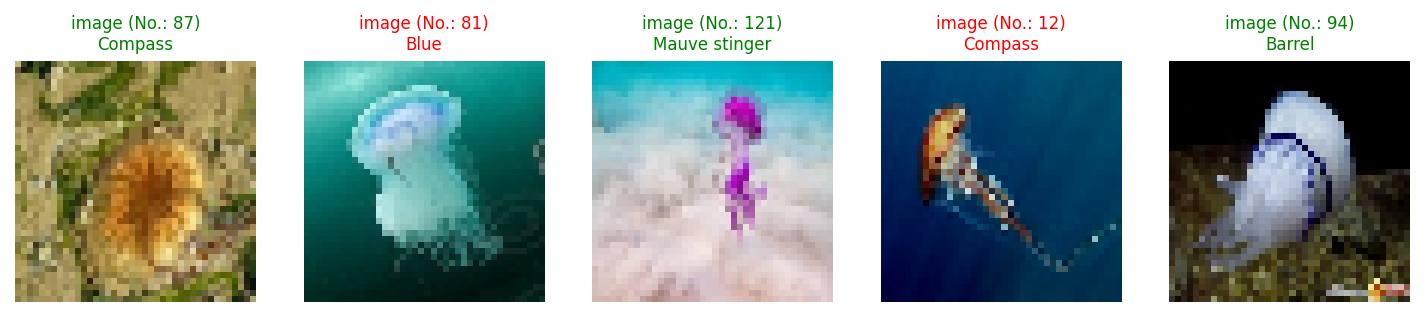

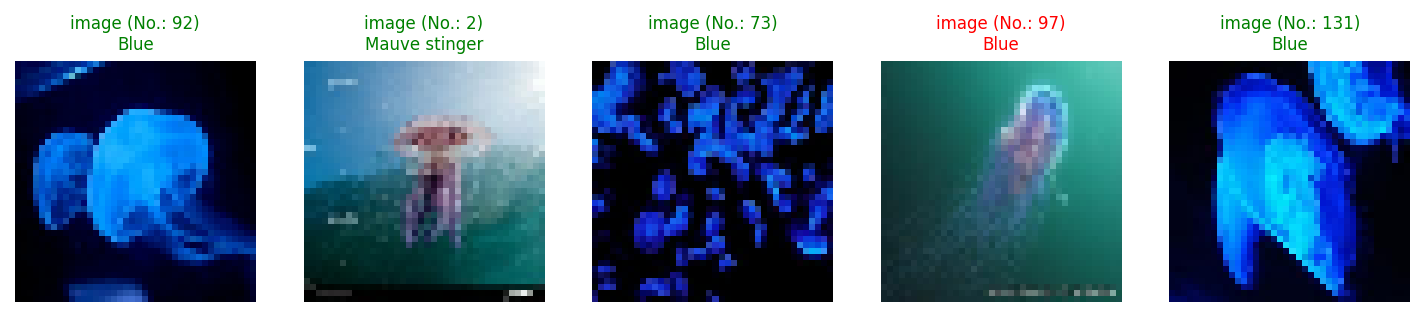

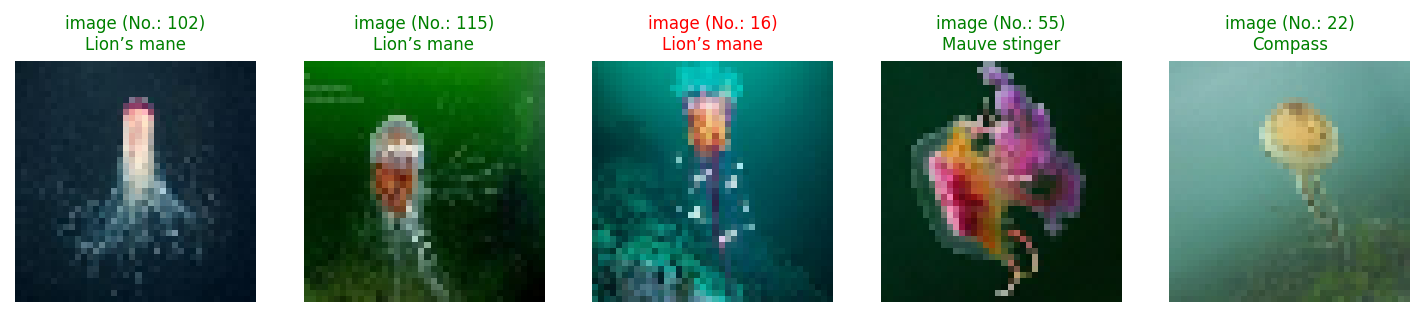

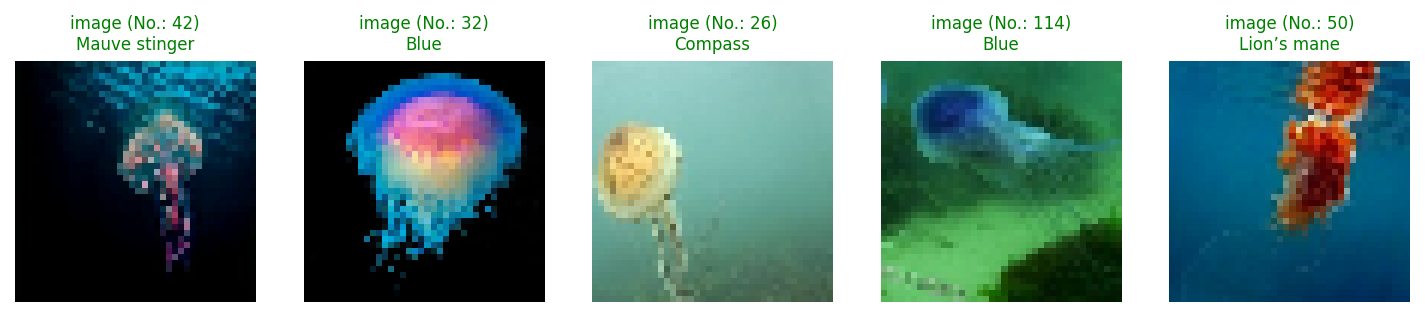

In [16]:
# 빨간색 제목 -> 잘못된 예측
# 초록색 제목 -> 올바른 예측

# SEED 값에 따라 다른 시드를 사용하여 무작위 테스트 샘플을 생성하고 예측 결과를 시각화합니다.
random_test_sample_with_prediction(SEED=145)  # SEED = 145에 대한 시각화
random_test_sample_with_prediction(SEED=7)    # SEED = 7에 대한 시각화
random_test_sample_with_prediction(SEED=78)   # SEED = 78에 대한 시각화
random_test_sample_with_prediction(SEED=98)   # SEED = 98에 대한 시각화